In [347]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt


data = pd.read_csv("dados/insurance.csv")
data = data.drop(['region'], axis='columns')  # A Coluna Região não é relevante para o modelo
data = data.drop(['sex'], axis='columns')  # A Coluna Sexo não é relevante para o modelo
data.head()

,age,bmi,children,smoker,charges
0,19,27.900,0,yes,16884.92400
1,18,33.770,1,no,1725.55230
2,28,33.000,3,no,4449.46200
3,33,22.705,0,no,21984.47061
4,32,28.880,0,no,3866.85520


In [348]:
data.isnull().sum()

age         0
bmi         0
children    0
smoker      0
charges     0
dtype: int64

Analisando as proporções de cada classe no conjunto de treino e teste: 

Proporção de cada classe no conjunto de teste:
weight_condition
Obese            0.529851
Overweight       0.287313
Normal Weight    0.167910
Underweight      0.014925
Name: count, dtype: float64

Proporção de cada classe no conjunto de treino:
weight_condition
Obese            0.528037
Overweight       0.288785
Normal Weight    0.168224
Underweight      0.014953
Name: count, dtype: float64


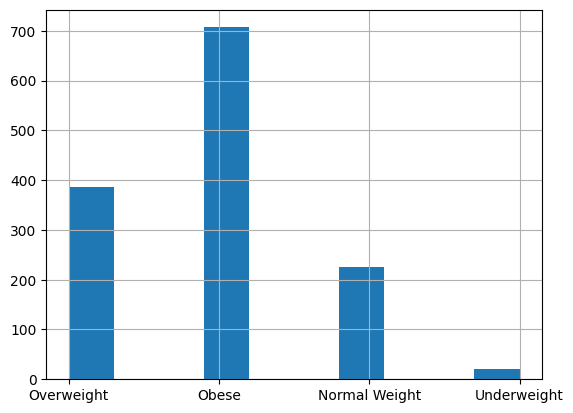

In [349]:

# Aplicando a Obesidade
# https://www.cancer.org/cancer/risk-prevention/diet-physical-activity/body-weight-and-cancer-risk.html
# IMC entre 25,0 e 29,9 Kg/m2: sobrepeso; 
# IMC entre 30,0 e 34,9 Kg/m2: obesidade grau I; 
# IMC entre 35,0 e 39,9 Kg/m2: obesidade grau II; 
# IMC maior do que 40,0 Kg/m2: obesidade grau III.
data["weight_condition"] = ""
for col in [data]:
    col.loc[col["bmi"] < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_condition"] = "Normal Weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_condition"] = "Overweight"
    col.loc[col["bmi"] >= 30, "weight_condition"] = "Obese"
    
data["weight_condition"].hist()

print("Analisando as proporções de cada classe no conjunto de treino e teste: ")
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in split.split(data, data["weight_condition"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
print("\nProporção de cada classe no conjunto de teste:")
print(strat_test_set["weight_condition"].value_counts() / len(strat_test_set))
print("\nProporção de cada classe no conjunto de treino:")
print(strat_train_set["weight_condition"].value_counts() / len(strat_train_set))


In [350]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# Removendo Outliers
from scipy.stats import zscore

#data['z_score'] = zscore(data['charges']) # Calcular o Z-Score para a coluna 'charges'
# Filtrar os dados para manter apenas os valores com Z-Score entre -3 e 3
#data_no_outliers_z = data[(data['z_score'] > -3) & (data['z_score'] < 3)]
#data = data_no_outliers_z.drop(columns=['z_score'])
#data.head()

# Preparando os dados
numeric_columns = [ 'age', 'bmi', 'children'] # Colunas numéricas
categorical_columns = [ 'smoker', 'weight_condition']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), #substituindo valores nulos pela mediana
    ('std_scaler', StandardScaler()), # padronizando as escalas dos dados
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numeric_columns), #tratando as variáveis numéricas (chamando a pipeline de cima)
    ("cat", OneHotEncoder(), categorical_columns), # tratando as variáveis categóricas
])

base_transformed = full_pipeline.fit_transform(data)
base_transformed_df = pd.DataFrame(base_transformed, columns=full_pipeline.get_feature_names_out())
base_transformed_df

,num__age,num__bmi,num__children,cat__smoker_no,cat__smoker_yes,cat__weight_condition_Normal Weight,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
0,-1.438764,-0.453320,-0.908614,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.509965,0.509621,-0.078767,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.797954,0.383307,1.580926,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.441948,-1.305531,-0.908614,1.0,0.0,1.0,0.0,0.0,0.0
4,-0.513149,-0.292556,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
1333,0.768473,0.050297,1.580926,1.0,0.0,0.0,1.0,0.0,0.0
1334,-1.509965,0.206139,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0
1335,-1.509965,1.014878,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0
1336,-1.296362,-0.797813,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0


In [351]:

# Removendo Outliers
if False:
    for column in ['charges']:
        Q1, Q3 = np.percentile(data[column], [25, 75])
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data_encoded = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# processando as Categorias: LabelEncoder ou OneHotEncoder? 
# LabelEncoder: converte as categorias em números inteiros
# OneHotEncoder: converte as categorias em variáveis binárias (0 ou 1)

#label_encoder = LabelEncoder()
#categorical_columns = [ 'smoker', 'weight_condition']
#for col in  categorical_columns:
#    data[col] = label_encoder.fit_transform(data[col])
    

#categorical_columns = [ 'smoker', 'weight_condition']
#data = pd.get_dummies(data = data,columns = categorical_columns,drop_first =True,dtype='int8')
#preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(sparse_output=False), categorical_columns)])
#preprocessor = ColumnTransformer(transformers=[('cat', OrdinalEncoder(), categorical_columns)])
#base_transformed = preprocessor.fit_transform(data)
#ase_transformed_df = pd.DataFrame(base_transformed, columns=preprocessor.get_feature_names_out())
data = pd.concat([data['charges'], base_transformed_df], axis=1)
data.head()


,charges,num__age,num__bmi,num__children,cat__smoker_no,cat__smoker_yes,cat__weight_condition_Normal Weight,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
0,16884.92400,-1.438764,-0.453320,-0.908614,0.0,1.0,0.0,0.0,1.0,0.0
1,1725.55230,-1.509965,0.509621,-0.078767,1.0,0.0,0.0,1.0,0.0,0.0
2,4449.46200,-0.797954,0.383307,1.580926,1.0,0.0,0.0,1.0,0.0,0.0
3,21984.47061,-0.441948,-1.305531,-0.908614,1.0,0.0,1.0,0.0,0.0,0.0
4,3866.85520,-0.513149,-0.292556,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0


charges                                1.000000
cat__smoker_yes                        0.787251
num__age                               0.299008
cat__weight_condition_Obese            0.199532
num__bmi                               0.198341
num__children                          0.067998
cat__weight_condition_Underweight     -0.044960
cat__weight_condition_Normal Weight   -0.106265
cat__weight_condition_Overweight      -0.120083
cat__smoker_no                        -0.787251
Name: charges, dtype: float64


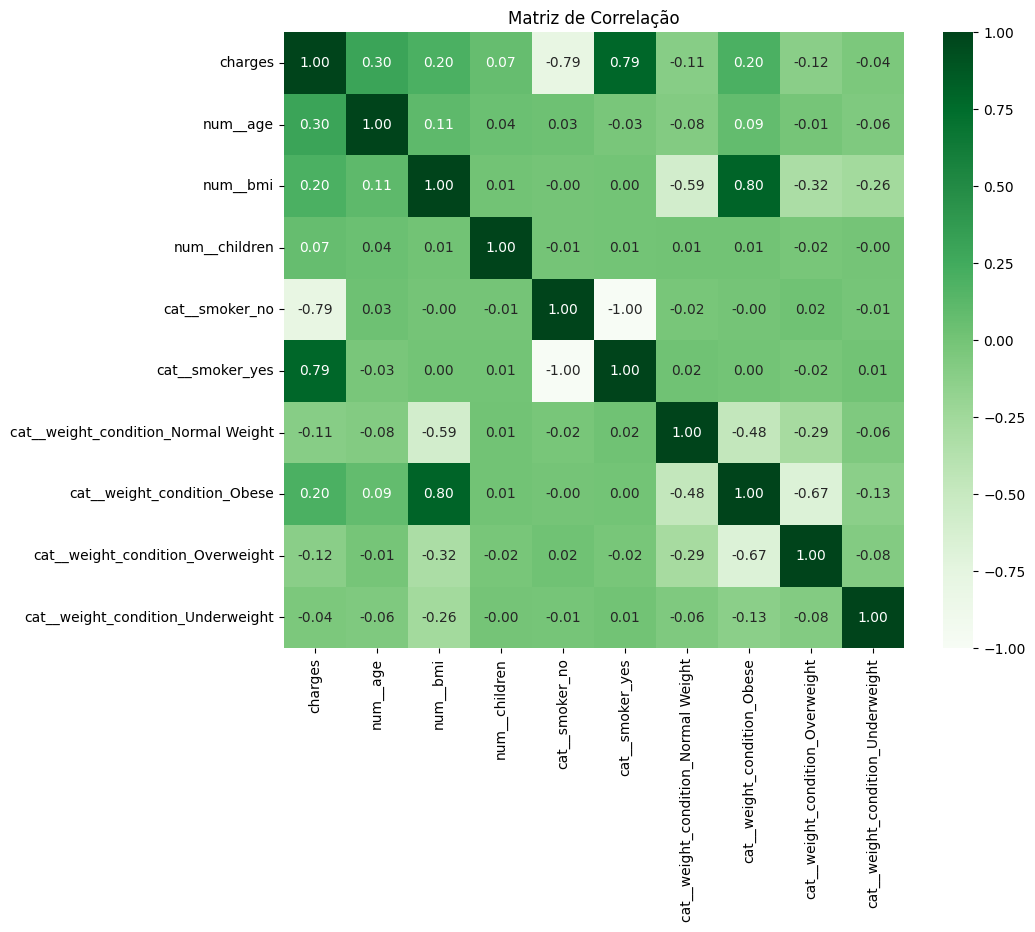

In [352]:

# Matriz de correlação
correlation_matrix = data.corr()
print(correlation_matrix["charges"].sort_values(ascending=False))

# Visualizar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [353]:
X = data.drop(['charges'], axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [354]:
X_train

,num__age,num__bmi,num__children,cat__smoker_no,cat__smoker_yes,cat__weight_condition_Normal Weight,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
621,-0.157143,0.563756,2.410772,0.0,1.0,0.0,1.0,0.0,0.0
194,-1.509965,0.617890,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0
240,-1.153959,0.985350,0.751079,0.0,1.0,0.0,1.0,0.0,0.0
1168,-0.513149,0.744205,0.751079,1.0,0.0,0.0,1.0,0.0,0.0
1192,1.338082,0.284060,-0.078767,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
763,-0.869155,-0.760083,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0
835,0.198863,0.870519,0.751079,1.0,0.0,0.0,1.0,0.0,0.0
1216,0.056461,-0.915925,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0
559,-1.438764,0.798339,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0


In [355]:
X_test

,num__age,num__bmi,num__children,cat__smoker_no,cat__smoker_yes,cat__weight_condition_Normal Weight,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
578,0.910875,-0.076018,-0.078767,1.0,0.0,0.0,1.0,0.0,0.0
610,0.554869,-0.212175,-0.078767,1.0,0.0,0.0,0.0,1.0,0.0
569,0.626070,1.624303,0.751079,0.0,1.0,0.0,1.0,0.0,0.0
1034,1.551686,1.265866,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0
198,0.839674,-2.069158,-0.908614,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
1084,1.622887,-0.027625,0.751079,1.0,0.0,0.0,1.0,0.0,0.0
726,0.127662,-0.370478,-0.078767,1.0,0.0,0.0,0.0,1.0,0.0
1132,1.266881,1.577551,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0
725,-0.655551,1.375776,1.580926,0.0,1.0,0.0,1.0,0.0,0.0


Modelo:  Ridge(alpha=0.5)
Mean Squared Error (MSE):  32285634.599949695
Mean Absolute Error (MAE):  4101.503190334343
R-squared (R2):  0.7971115299166971


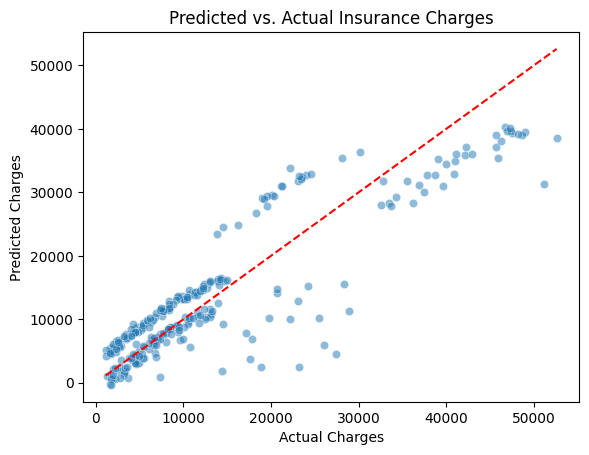

-------------------
Modelo:  Lasso(alpha=0.2)
Mean Squared Error (MSE):  32285488.56359761
Mean Absolute Error (MAE):  4101.3793500016145
R-squared (R2):  0.7971124476342027


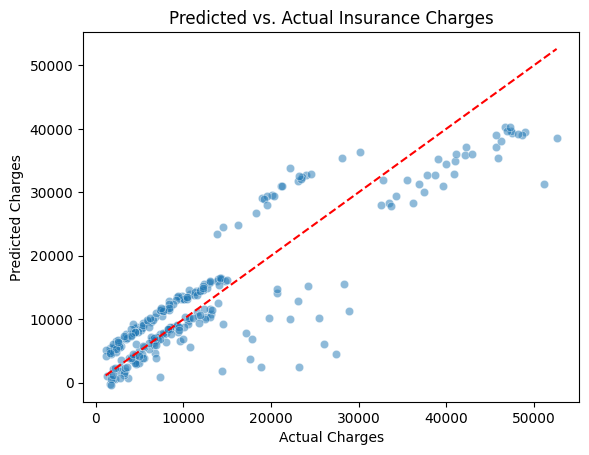

-------------------
Modelo:  LinearRegression()
Mean Squared Error (MSE):  32288223.845232166
Mean Absolute Error (MAE):  4101.795298155491
R-squared (R2):  0.7970952586548639


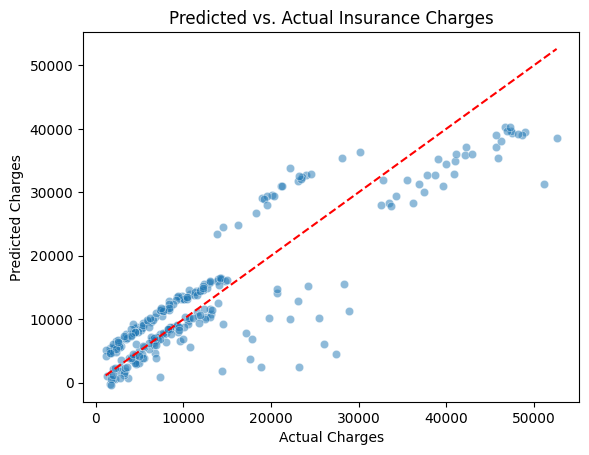

-------------------
Modelo:  DecisionTreeRegressor()
Mean Squared Error (MSE):  52930611.96586904
Mean Absolute Error (MAE):  3470.5665336902985
R-squared (R2):  0.6673749481651859


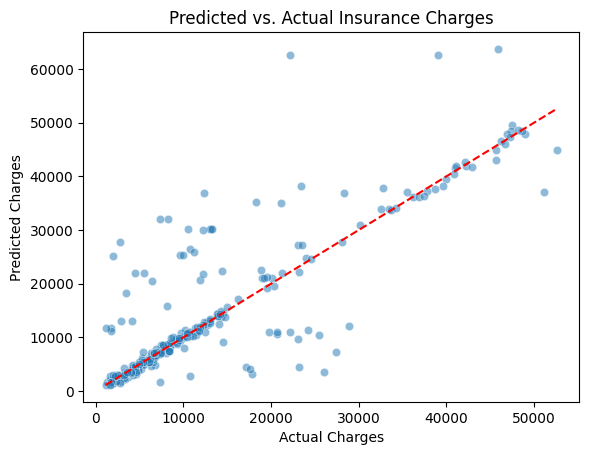

-------------------
Modelo:  RandomForestRegressor(criterion='friedman_mse', max_depth=18, max_leaf_nodes=12,
                      n_estimators=200, n_jobs=-1, random_state=1)
Mean Squared Error (MSE):  17692052.069906853
Mean Absolute Error (MAE):  2530.28301729412
R-squared (R2):  0.8888201077174079


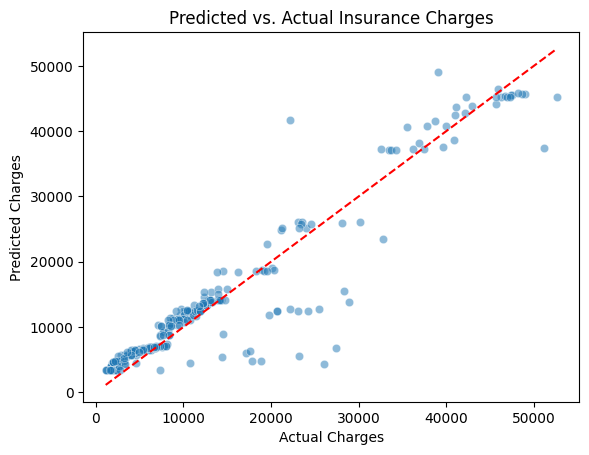

-------------------
Modelo:  KNeighborsRegressor(n_neighbors=20)
Mean Squared Error (MSE):  19762517.298601996
Mean Absolute Error (MAE):  2662.169878871269
R-squared (R2):  0.8758089487974812


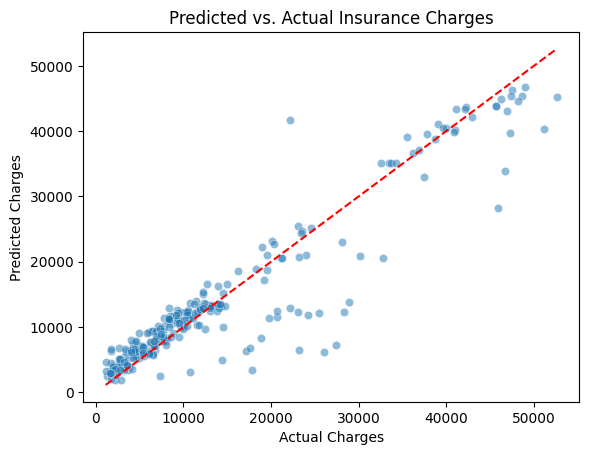

-------------------


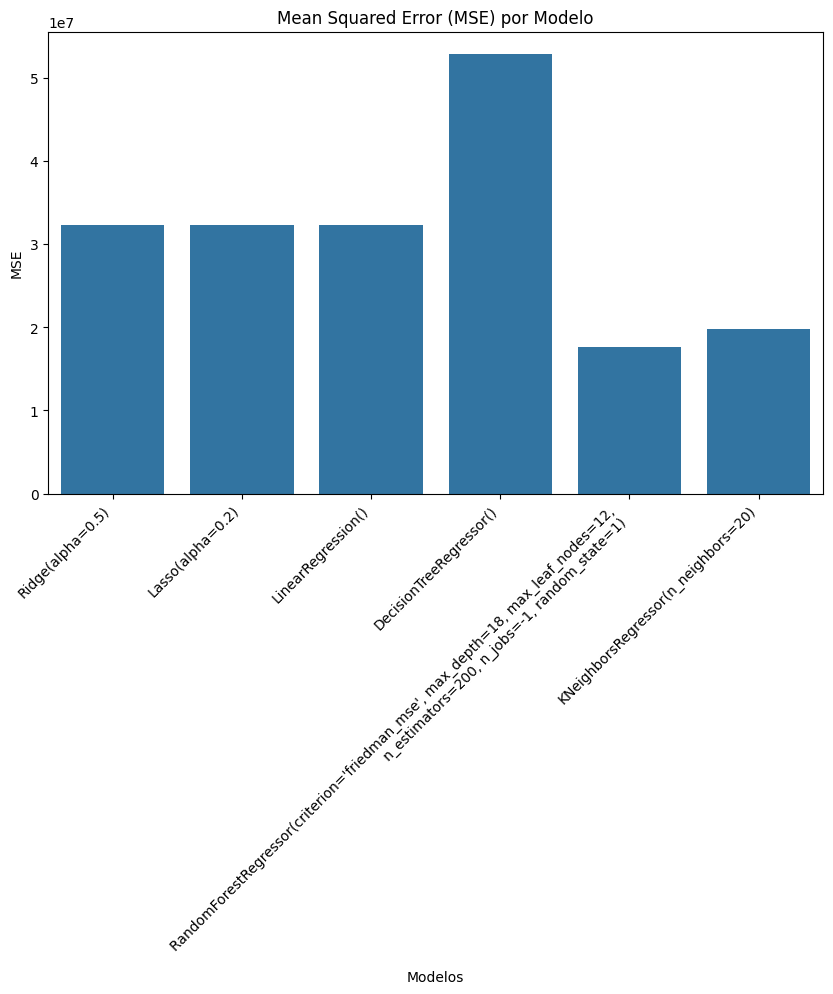

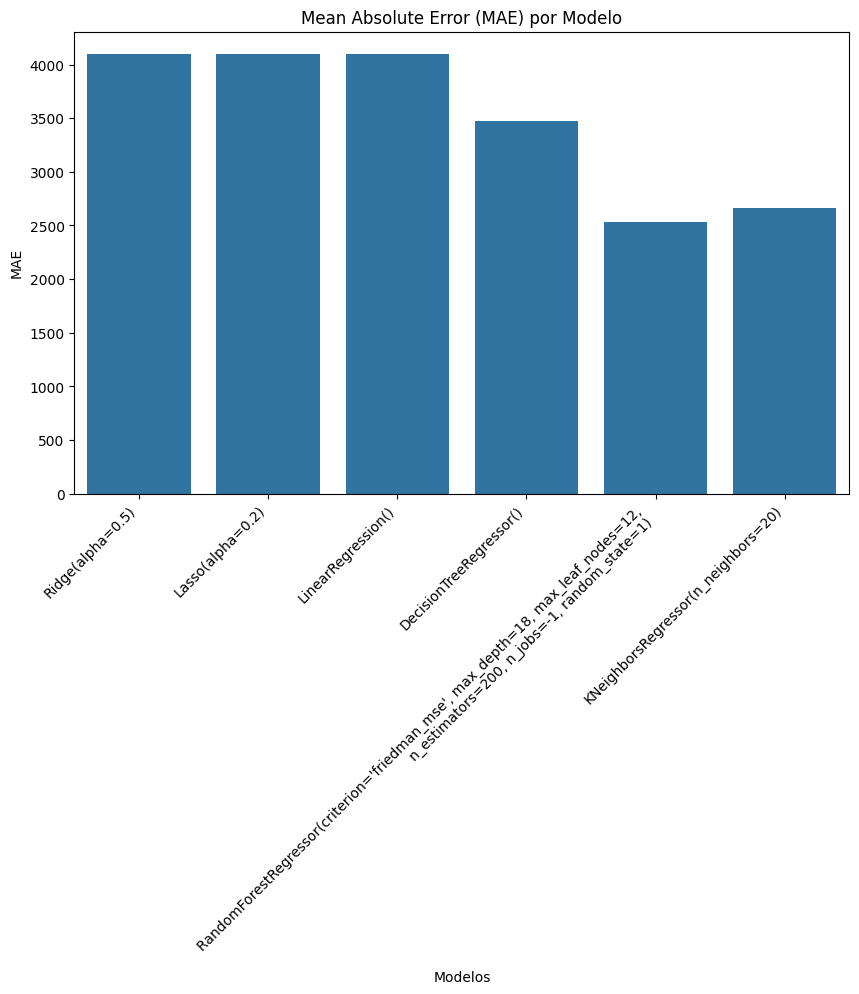

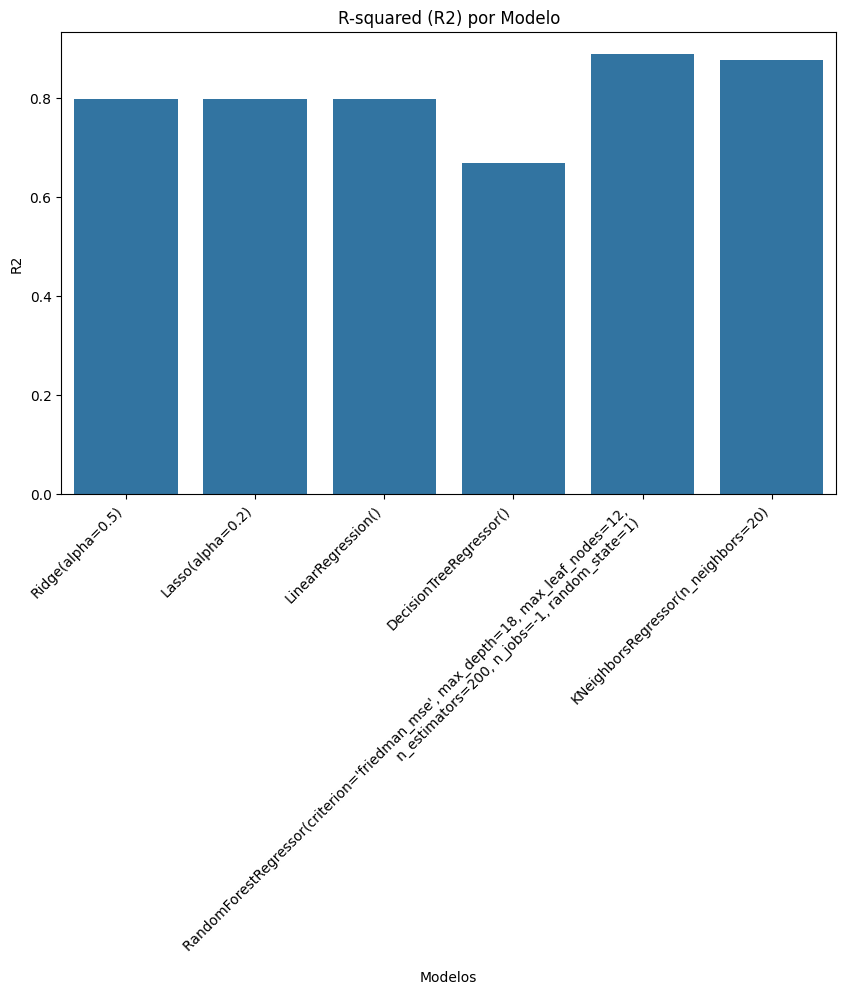

O melhor modelo é RandomForestRegressor(criterion='friedman_mse', max_depth=18, max_leaf_nodes=12,
                      n_estimators=200, n_jobs=-1, random_state=1) com R2 de 0.8888, MSE de 17692052.0699 e MAE de 2530.2830.


In [356]:

# Selecionando alguns modelos e verificando o desempenho
models = [
    Ridge(alpha=0.5),
    Lasso(alpha=0.2, fit_intercept=True, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic'),
    LinearRegression(), 
    DecisionTreeRegressor(), 
    RandomForestRegressor(n_estimators=200, 
                          max_depth=18, max_leaf_nodes=12,
                          criterion = 'friedman_mse',
                        random_state = 1,
                        n_jobs = -1),
    KNeighborsRegressor(n_neighbors=20)
]
metrics_results = []

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("Modelo: ", model)
    print('Mean Squared Error (MSE): ', mse)
    print('Mean Absolute Error (MAE): ', mae)
    print('R-squared (R2): ', r2)
    
    # Criando um DataFrame para armazenar os valores reais e previstos
    results = pd.DataFrame({
        "Actual Charges": y_test,
        "Predicted Charges": y_pred
    })
    
    sns.scatterplot(data=results, x="Actual Charges", y="Predicted Charges", alpha=0.5)
    plt.plot(
        [results["Actual Charges"].min(), results["Actual Charges"].max()],
        [results["Actual Charges"].min(), results["Actual Charges"].max()],
        color='red',
        linestyle='--'
    )
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title("Predicted vs. Actual Insurance Charges")
    plt.show()
    print('-------------------')
    metrics_results.append((model, mse, mae, r2))
    

# Criando gráficos para comparar as métricas de cada modelo
metrics_df = pd.DataFrame(metrics_results, columns=["Model", "MSE", "MAE", "R2"])

# Gráfico de MSE
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x="Model", y="MSE")
plt.xticks(rotation=45, ha="right")
plt.title("Mean Squared Error (MSE) por Modelo")
plt.ylabel("MSE")
plt.xlabel("Modelos")
plt.show()

# Gráfico de MAE
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x="Model", y="MAE")
plt.xticks(rotation=45, ha="right")
plt.title("Mean Absolute Error (MAE) por Modelo")
plt.ylabel("MAE")
plt.xlabel("Modelos")
plt.show()

# Gráfico de R2
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x="Model", y="R2")
plt.xticks(rotation=45, ha="right")
plt.title("R-squared (R2) por Modelo")
plt.ylabel("R2")
plt.xlabel("Modelos")
plt.show()

# Análise do melhor modelo
melhor_modelo = metrics_df.loc[metrics_df["R2"].idxmax()]
print(f"O melhor modelo é {melhor_modelo['Model']} com R2 de {melhor_modelo['R2']:.4f}, MSE de {melhor_modelo['MSE']:.4f} e MAE de {melhor_modelo['MAE']:.4f}.")

Modelo:  RandomForestRegressor(criterion='friedman_mse', max_depth=20, max_leaf_nodes=17,
                      n_estimators=7, random_state=1)
Mean Squared Error (MSE):  15811264.726478495
Mean Absolute Error (MAE):  2393.7231158087056
O MAPE é: 30.37%
R-squared (R2):  0.9006392982455946


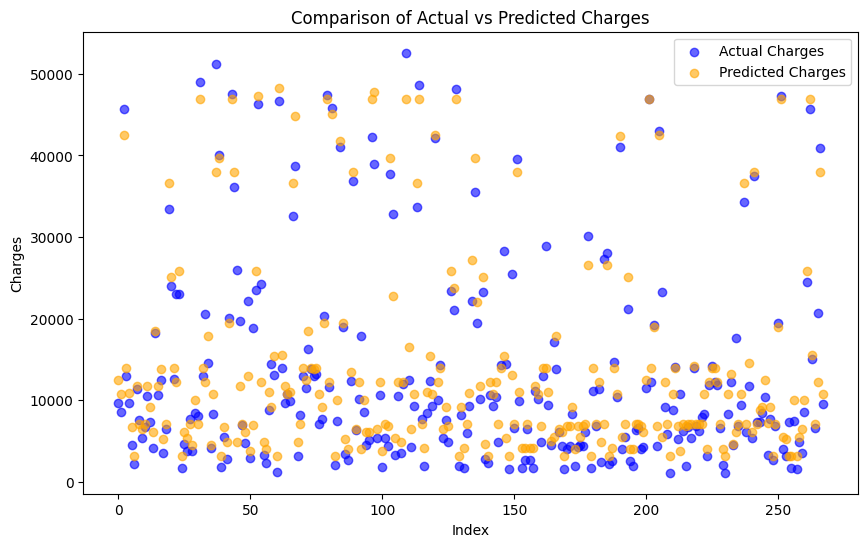

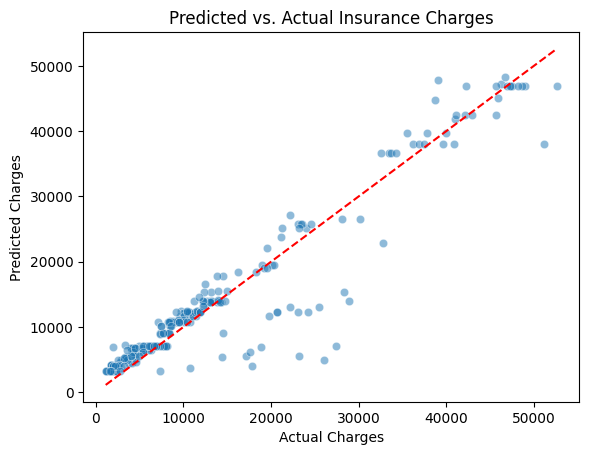

-------------------
Modelo:  KNeighborsRegressor()
Mean Squared Error (MSE):  19487061.310373407
Mean Absolute Error (MAE):  2628.3584441231346
O MAPE é: 35.23%
R-squared (R2):  0.877539961513182


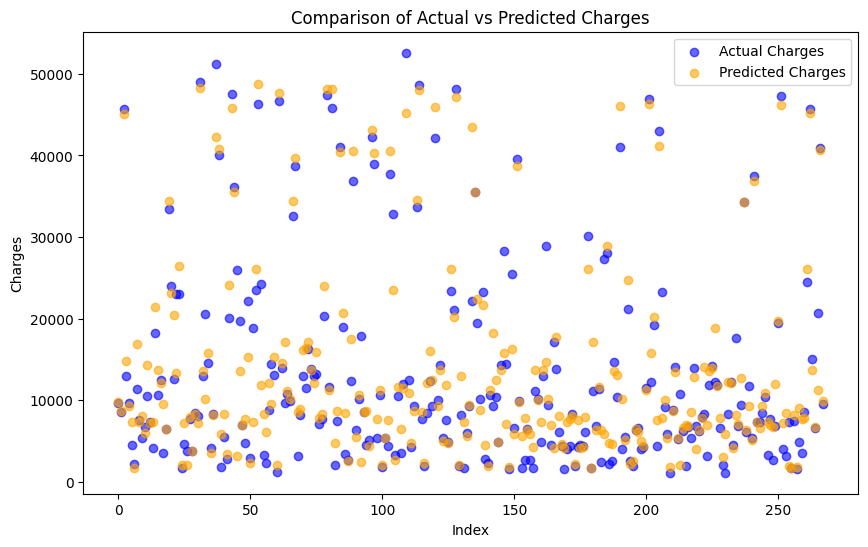

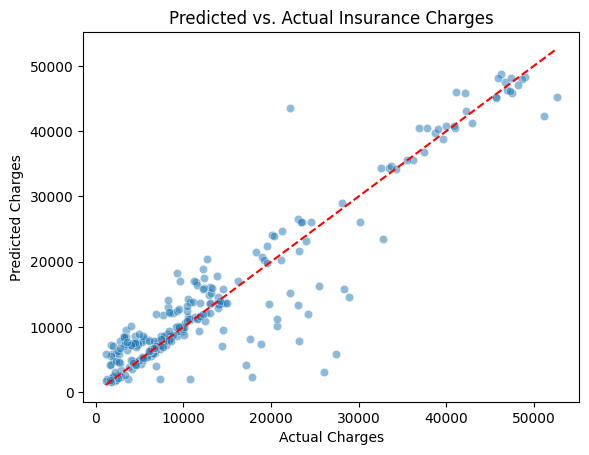

-------------------


In [363]:
# Selecionando alguns modelos e verificando o desempenho
models = [
    RandomForestRegressor(n_estimators=7, max_depth=20, max_leaf_nodes=17, criterion = 'friedman_mse', random_state = 1),
    KNeighborsRegressor(n_neighbors=5)
]

# Função para calcular o MAPE (Mean Absolute Percentage Error)

def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape_result = calculate_mape(y_test, y_pred)
    
    print("Modelo: ", model)
    print('Mean Squared Error (MSE): ', mse)
    print('Mean Absolute Error (MAE): ', mae)
    print(f"O MAPE é: {mape_result:.2f}%")
    print('R-squared (R2): ', r2)
    
    # Criando um DataFrame para armazenar os valores reais e previstos
    
    results = pd.DataFrame({
        "Actual Charges": y_test,
        "Predicted Charges": y_pred
    })
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Charges', alpha=0.6)
    plt.scatter(range(len(y_pred)), y_pred, color='orange', label='Predicted Charges', alpha=0.6)
    plt.title("Comparison of Actual vs Predicted Charges")
    plt.xlabel("Index")
    plt.ylabel("Charges")
    plt.legend()
    plt.show()
    
    sns.scatterplot(data=results, x="Actual Charges", y="Predicted Charges", alpha=0.5)
    plt.plot(
        [results["Actual Charges"].min(), results["Actual Charges"].max()],
        [results["Actual Charges"].min(), results["Actual Charges"].max()],
        color='red',
        linestyle='--'
    )
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title("Predicted vs. Actual Insurance Charges")
    plt.show()
    print('-------------------')
    
